In [16]:
using MAT
using DataFrames
using RCall
# import Pkg; Pkg.add("MAT")

In [17]:
vars  = matread("fig/performance_throughput/Toughest_regime_experiment_size200clusters.mat")
to_df = Dict(key => vec(val) for (key, val) in vars if key != "pvals")

DF = DataFrame(to_df)

,Kvals,Nvals,aris,aris_dyadic,aris_refine,aris_udyadic,aris_urefine
,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,100,10000,0.414238,0.21296,0.421788,0.000971924,0.0277757
2,129,16681,0.456049,0.346884,0.600645,0.000890791,0.0392533
3,167,27826,0.454997,0.443859,0.719431,0.000774026,0.0413923
4,215,46416,0.48287,0.471695,0.750577,0.00058384,0.0233708
5,278,77426,0.487715,0.489614,0.771005,0.000518779,0.0226361
6,359,129155,0.491841,0.497597,0.79115,0.000451222,0.0253351
7,464,215443,0.51,0.510749,0.803019,0.000409389,0.00915455
8,599,359381,0.512056,0.51189,0.803256,0.000361018,0.00457003
9,774,599484,0.518053,0.518376,0.809118,0.000329791,0.00520927


In [18]:
DF[:,:runs]

10-element Array{Float64,1}:
    33.6673150062561
    55.11304807662964
   140.6331799030304
   347.4928319454193
   677.5101659297943
  1667.7779121398926
  3546.907639980316
  8854.575985908508
 24036.31467604637
 55342.07998204231

In [19]:
R"""
library(tidyverse)
df <- tibble($DF)
""";

In [20]:
R"""
df$runs_urefine
"""

RObject{RealSxp}
 [1]    9.244544   24.037765   64.985273  164.194293  248.359286  433.319541
 [7]  835.924606  930.628679 2405.596785 4272.363748


┌ Warning: RCall.jl: Warning: Expected 2 pieces. Missing pieces filled with `NA` in 30 rows [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, ...].
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


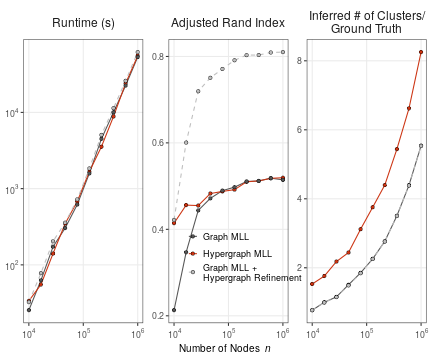

RObject{VecSxp}


In [21]:
R"""
plot_df <- df %>% 
    select(Kvals, Nvals, aris, aris_dyadic, aris_refine, cnum, cnum_dyadic, cnum_refine, runs, runs_dyadic, runs_refine) %>% 
    mutate(runs_refine = runs_dyadic + runs_refine) %>% 
    pivot_longer(cols = c(aris, aris_dyadic, aris_refine, cnum, cnum_dyadic, cnum_refine, runs, runs_dyadic, runs_refine), names_to = "metric", values_to = "value" ) %>% 
    separate(metric, c("metric", "method"), "_") %>% 
    mutate(method = ifelse(is.na(method), "polyadic", method)) %>% 
    mutate(
           value = ifelse(metric == "runs", log10(value), value),
           value = ifelse(metric == "cnum", value/Kvals, value), 
           metric = case_when(
                metric == "aris" ~ "Adjusted Rand Index", 
                metric == "cnum" ~ "Inferred # of Clusters/\nGround Truth",
                metric == "runs" ~ "Runtime (s)"
            ),
            method = case_when(
                method == "dyadic"   ~ "Graph MLL", 
                method == "polyadic" ~ "Hypergraph MLL",
                method == "refine"   ~ "Graph MLL +\nHypergraph Refinement"
            )) %>% 
    mutate(method = factor(method, levels = c("Graph MLL","Hypergraph MLL", "Graph MLL +\nHypergraph Refinement")),
          metric = factor(metric, levels = c("Runtime (s)","Adjusted Rand Index", "Inferred # of Clusters/\nGround Truth"))
            ) 
    
my_breaks <- function(x) { 
    if( (max(x) < 8) &&  (max(x) > 1))
        return(seq(0, 5, 1))
    
    if(max(x) < 1)
        return(seq(0.2, 1, .2)) 
    
    return(seq(0, 8, 2))
}

my_labels <- function(breaks){
    x = breaks
    if( (max(x, na.rm = T) < 8) &&  (max(x, na.rm = T) > 1)){
        return(parse(text=paste0("10^", breaks)))
    }
    return(breaks)
}

scientific_10 <- function(x) {
  parse(text=paste0("10^", scales::scientific_format()(log10(x))))
}

plot_df %>% 
    ggplot() + 
    aes(x = Nvals, y = value) + 
    geom_line(aes(color = method, linetype = method)) + 
    geom_point(aes(fill = method), pch = 21, stroke = 0.3) + 
    facet_wrap(~metric, scales = "free_y") +
    scale_x_continuous(trans = "log10", labels = scientific_10) + 
    scale_y_continuous(breaks = my_breaks, labels = my_labels) + 
    theme_bw() + 
    theme(strip.background = element_blank(),
          panel.spacing = unit(3, "mm"),
          strip.text = element_text(size = 12),
          legend.text = element_text(size = 9),
          panel.grid.minor = element_blank(),
          legend.key.width = unit(0.7,"line"),
          legend.position = c(.55, .25),
          legend.background = element_blank(), 
          legend.key = element_rect(colour = NA, fill = NA),
          axis.title = element_text(size = 10),
          legend.title = element_blank(),
          axis.title.y = element_blank()) + 
    scale_color_manual(values = c("#555555", "#CC3311", "#bdbdbd")) + 
    scale_fill_manual(values = c("#555555", "#CC3311",  "#bdbdbd")) + 
    scale_linetype_manual(values = c(1, 1, 2)) + 
    ylab("") + 
    xlab(expression("Number of Nodes"~italic(n)))          
"""

In [22]:
R"""
ggsave("fig/performance.png", width = 8, height = 3)
"""

RObject{NilSxp}
NULL
